## Introduction to Dask

Why do we like Python for data science??? It has this amazing ecosystem of libraries that work together:
* NumPy
* SciPy
* scikit-image
* scikit-learn
* pandas
* matplotlib
 
That center around a couple of core concepts:
* dense arrays (NumPy)
* data frames (pandas)
   
But all of this (and python for the most part) is serial.  And we live in a parallel world.  Let me actually refine and unpack this:
  * many functions may be parallelized internally
    * NumPy routines link against a C/C++-library, such as atlas or MKL, that execute in parallel
  * any python code that you write is serial
  
__Capablity gap__: a parallel runtime for this ecosystem that is intuitive to the python data scientist.

According to the [official dask tutorial](https://github.com/dask/dask-tutorial) "Dask is a parallel computing library that scales the existing Python ecosystem."  It also states that "Dask can scale down to your laptop and up to a cluster", which implies that Dask will run on distributed memory.

### Core Concepts in Data Parallel Computing 

I like to think of Dask as a parallel computing framework that has evolved from Google's Map/Reduce and mostly similar to Spark. This is also how I use the tool. The dask community points out some [differences](https://docs.dask.org/en/latest/spark.html). The most notable are:
  * multi-dimensional array support
  * lower-level programming interfaces for power users (most people don't care)
  * integration with the python ecosystem (this is important)
  
Some important concepts in common are:

* __Data Parallel Programming__: The framework breaks data structures into independendent pieces and executes functions against those pieces.
* __Automated Parallelism__: The programmer has no interaction with the number of processes/threads/worker.  These are chosen by the runtime system. The exact same program runs on clusters as on laptops.
* __Declarative Programming__: The programmer tells the framework _WHAT_ to compute not _HOW_ to compute it. 
  * This differs from __imperative__ programming in which the programmer tells the computer exactly what steps to take and in what order.  This is what we're used to in Python.
  * Declarative programming allows the runtime system to make many optimizations. It can choose an execution order that reduces memory consumption, perform independent steps in parallel, share data accross computations.
  * Declarative programming is typically less intuitive.
  
OK, let's learn by example.  BTW -- we need to add HDF5, a scientific data format, to our python environment.
```sh
conda install h5py
```

### A First Dask Program

This was my first dask program working with computational fluids (turbulence) data from the [Johns Hopkins Turbulence Database](http://pha.jhu.edu/turbulence).

In [1]:
import numpy as np
import dask.array as da
import h5py

# load a file and grab the data
f = h5py.File("./data/isotropic4096.h5","r")
d = f['u00000']

# convert data into a dask array
uvec = da.from_array(d[0,:,:,:], chunks=(64, 64, 3))
uvec

,Array,Chunk
Bytes,48.00 MiB,48.00 kiB
Shape,"(2048, 2048, 3)","(64, 64, 3)"
Count,1024 Tasks,1024 Chunks
Type,float32,numpy.ndarray


This data is a velocity field in a plane of 2048x2048 cells with three orthogonal components $(u,v,z)$ in the $(x,y,z)$ dimensions.  This is a small cut of a large numerical simulation $(8192^3)$. This is a typical data analysis patter, e.g. to examine flow through a plane.

In [3]:
# take the velocity magnitude at each location
umag = da.linalg.norm(uvec, axis=2)
umag

dask.array<pow, shape=(2048, 2048), dtype=float64, chunksize=(64, 64), chunktype=numpy.ndarray>

The `norm` function computes the vector magnitude at each location, turning this into a scalar field.

### Distributed Data Structures

Dask converted an input array into _chunks_ each of which can be computed on independently.
The _norm()_ function computes the magnitude of the components at each site. Dask creates a 'task' for each data chunk.  This is __data decomposition__. The division of the data into parts defines the parallelism.  A task may be a thread or a process depending upon the runtime environment.

### Lazy Evaluation

But, dask has done no computation at this point. It has created a computational workflow that it will only execute when the data is actually needed.  If we ask for the description of the distributed data structure, it takes almost no time at all. 

In [ ]:
%%timeit
umag

Only when we ask it to compute the output does the work get done.

In [ ]:
%%timeit
umag.compute()

In [4]:
umag.compute()

array([[3.36865189, 3.38269484, 3.39613688, ..., 0.35552506, 0.42720882,
        0.48777572],
       [3.39010173, 3.40562469, 3.41906076, ..., 0.34237043, 0.41770322,
        0.48341892],
       [3.4141839 , 3.42888766, 3.44117541, ..., 0.33960752, 0.41539671,
        0.48326439],
       ...,
       [4.40146098, 4.23910124, 4.08794059, ..., 4.04412574, 4.02879924,
        4.01608203],
       [4.39772538, 4.2277415 , 4.06553138, ..., 4.05115737, 4.0319129 ,
        4.01446463],
       [4.40407135, 4.23276965, 4.06173331, ..., 4.06355288, 4.04077055,
        4.01843419]])

Now let's take a look at it. This is a forced isotropic turbulence flow at a Reynold's number of 433. 

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
plt.imshow(umag, cmap='viridis', interpolation='nearest')
plt.show()

### Execution Graphs

For this, we'll need to work with a smaller data set.  dask builds a schedule of computation based on the partitions of data and then defines tasks.

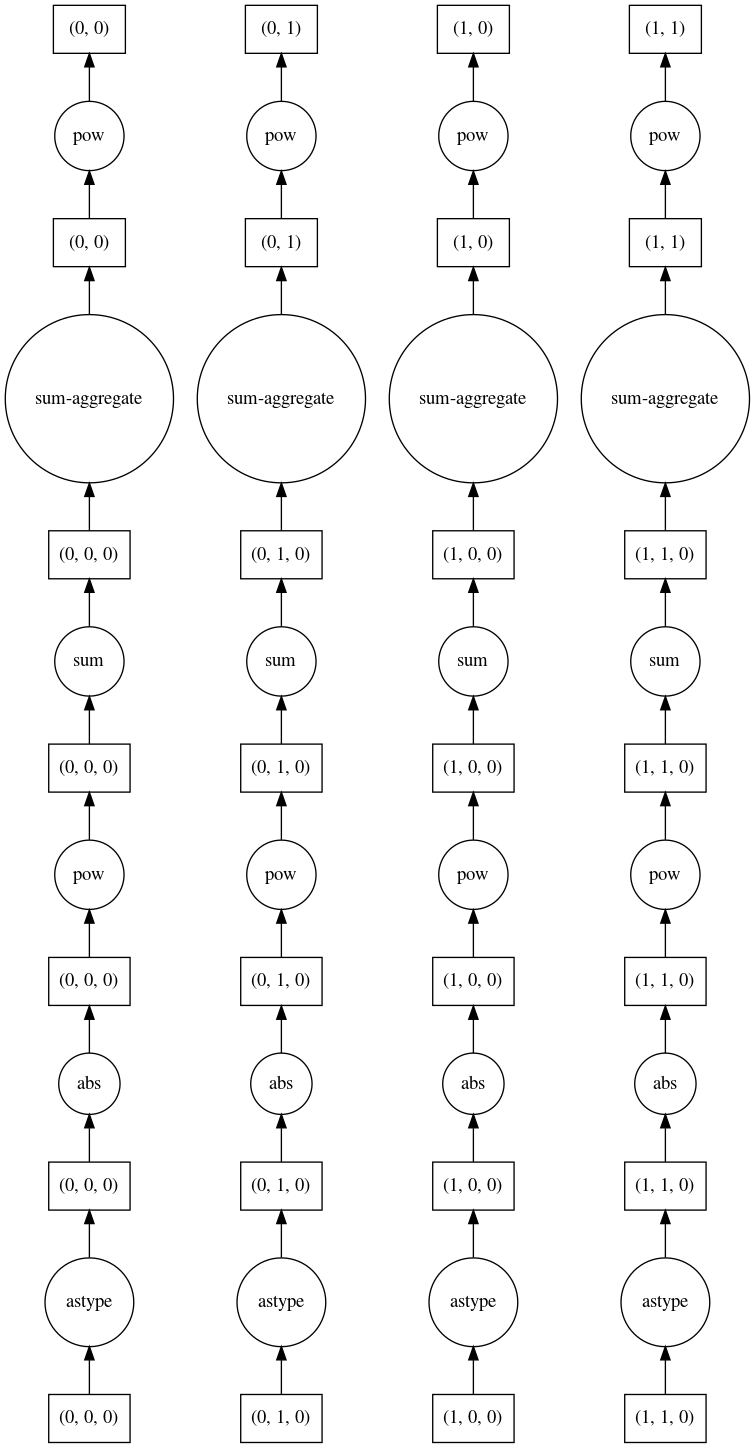

In [5]:
# convert data into a dask array
#sm_uvec = da.from_array(d[0,:,:,:], chunks=(64, 64, 3))
sm_uvec = da.from_array(d[0,0:128,0:128,:], chunks=(64, 64, 3))
sm_umag = da.linalg.norm(sm_uvec, axis=2)
sm_umag.visualize()

The goal is to compute for every cell

$$
umag =\sqrt{{u}^2+{v}^2+{w}^2}
$$

Dask performs numpy array operations (vectorized) on each of four partitions defined by our input.  The aggregate function changes the partitioning function from three-dimensional (0,1,0) to two-dimensional (0,1). There are no data dependencies between the different computational paths.

The execution graph is defined prior to the computation, we haven't done anything yet. 

Dask will use this execution graph to do several things:
* __localize the computation__: if only part of the output is requested, dask computes only that portion of the graph.
* __distribute the computation__: different nodes/paths of the graph are computed on different cores or compute nodex
* __asynchronous scheduling__: execute parts of the graph at different time for load balancing, data reuse, resource minimization
  * it typically makes sense to perform multiple steps in an independent path at once so that the data output by a prior step is in cache as input to the next step.
  
The dask tutorial has a _very nice_ visualization of a simulated extract, transform, and load (ETL) data cleaning workload.

![this](images/grid_search_schedule.gif)

You can see the the engine performs partitions/tasks to completion (bottom to top) before working on other partitions.  This reduces the memory footprint of the computation.

It looks to me like this is running on a two-core machine, i.e. there are two parallel execution regions at the same time. With more cores, it would like more like a breadth-first traversal.

### Review of Dask Concepts

* Distributed data structures: data is partitioned into chunks that can be operated on independenlty and in parallel. Dask operators output chunked data (whenever possible) to serve as the input to the next parallel step.
* Lazy evaluation: when operations are defined, dask builds an execution graph.  Dask schedules computation on that graph only when the outputs are requested, typically by calling compute().